### Implementing LSTM Nueral Network

### Data Preparation

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import sys
sys.path.append(r'C:\Projects\ML Stock Predictor\MLStockPredictor\src')
import data_preparation as dp

df_lstm = dp.download_stock_data('AAPL', '2010-01-01', '2023-10-01')
df_lstm = dp.add_target(df_lstm)

df_scaled, scaler = dp.scale_features(df_lstm.drop(columns=['Target']))
df_scaled['Target'] = df_lstm['Target']  # Add target back

features = ['Open', 'High', 'Low', 'Close', 'Volume']
target = 'Target'
df_lstm.sort_index(inplace=True)

seq_len = 60
X_all, y_all = dp.create_lstm_sequences(df_scaled, features, trget, seq_len)

print(df_lstm.head())

[*********************100%***********************]  1 of 1 completed

Price           Open      High       Low     Close     Volume Target
Ticker          AAPL      AAPL      AAPL      AAPL       AAPL       
Date                                                                
2010-01-04  6.414466  6.446624  6.382909  6.431898  493729600      1
2010-01-05  6.449628  6.479381  6.409054  6.443016  601904800      0
2010-01-06  6.443016  6.468562  6.333919  6.340531  552160000      0
2010-01-07  6.363975  6.371489  6.282828  6.328811  477131200      1
2010-01-08  6.320395  6.371487  6.283128  6.370886  447610800      0



C:\Users\Baile\AppData\Local\Temp\ipykernel_7560\2420859606.py:11: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df_scaled, scaler = dp.scale_features(df_lstm.drop(columns=['Target']))


### Data Split

In [25]:
# splitting sequentially same as before
train_size = int(len(X_all) * 0.8)
X_train, X_test = X_all[:train_size], X_all[train_size:]
y_train, y_test = y_all[:train_size], y_all[train_size:]

# convert to pytorch tensors
X_train_t = torch.tensor(X_train)
# unsqueeze is to add an extra dimension so that it matches the output shape
y_train_t = torch.tensor(y_train).unsqueeze(-1)
X_test_t  = torch.tensor(X_test)
y_test_t  = torch.tensor(y_test).unsqueeze(-1)

### Model Definition

In [26]:
# class for calling the LSTM model and then a fully connected layer
class LSTMRegressor(nn.Module):
    # there are more parameters to mess around with for the model, but I kept it pretty simple for now
    def __init__(self, input_size, hidden_size=64, num_layers=2, output_size=1):
        super(LSTMRegressor, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        # fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)

    # pass input through LSTM for predictions
    def forward(self, x):
        lstm_out, (h_n, c_n) = self.lstm(x)
        last_step = lstm_out[:, -1, :]
        y_pred = self.fc(last_step)
        return y_pred

### Model Training

In [27]:
import torch.optim as optim
# create model with number of features as the input size
model = LSTMRegressor(input_size=len(features), hidden_size=64, num_layers=2, output_size=1)
# define loss function
criterion = nn.MSELoss()
# optimizer for updating model params
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)
# training mode
model.train()

# Values to play around with, epochs run quite fast on GPU but results do not get much better aftr 150 I have found
num_epochs = 150
batch_size = 32

# training loop
for epoch in range(num_epochs):
    total_loss = 0
    for i in range(0, len(X_train_t), batch_size):
        x_batch = X_train_t[i : i + batch_size]
        y_batch = y_train_t[i : i + batch_size]

        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    # printing results every 10 epochs
    if (epoch + 1) % 10 == 0:
        avg_loss = total_loss / (len(X_train_t) // batch_size)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")
    scheduler.step()

Epoch 10/150, Loss: 0.2528
Epoch 20/150, Loss: 0.2529
Epoch 30/150, Loss: 0.2525
Epoch 40/150, Loss: 0.2523
Epoch 50/150, Loss: 0.2530
Epoch 60/150, Loss: 0.2514
Epoch 70/150, Loss: 0.2498
Epoch 80/150, Loss: 0.2489
Epoch 90/150, Loss: 0.2454
Epoch 100/150, Loss: 0.2394
Epoch 110/150, Loss: 0.2324
Epoch 120/150, Loss: 0.2286
Epoch 130/150, Loss: 0.2267
Epoch 140/150, Loss: 0.2242
Epoch 150/150, Loss: 0.2218


### Model Evaluation

In [28]:
# evaluation mode
model.eval()
with torch.no_grad():
    # test predictions and loss
    y_pred_test = model(X_test_t)
    test_loss = criterion(y_pred_test, y_test_t).item()

print("Test MSE:", test_loss)

Test MSE: 0.3934215009212494


### Results Visualization

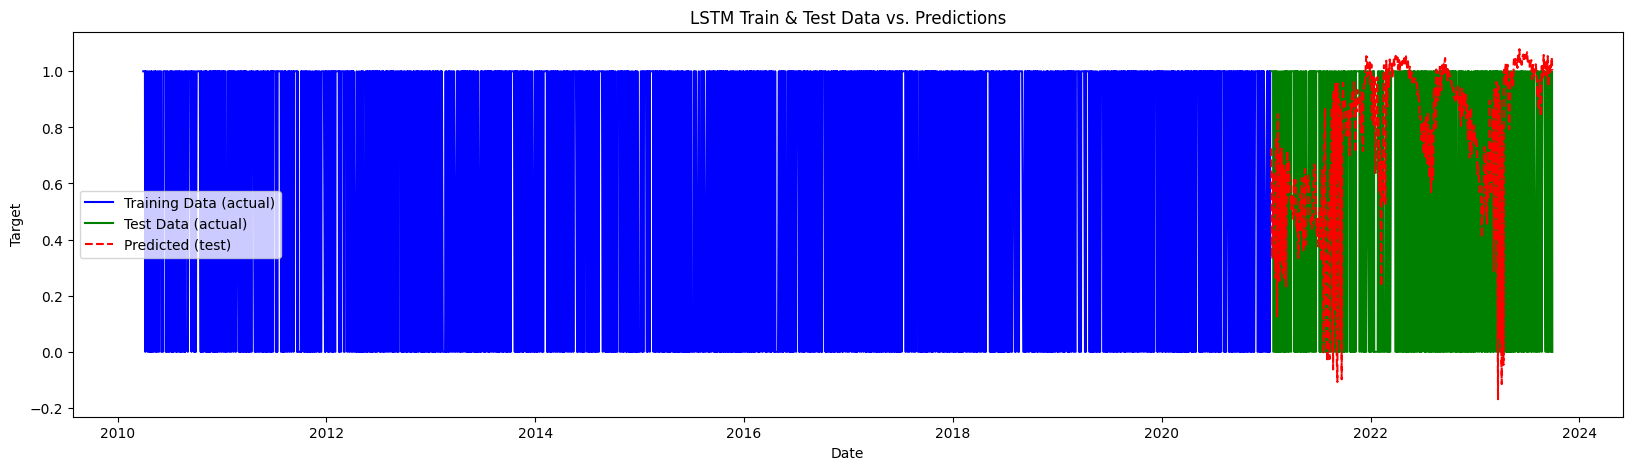

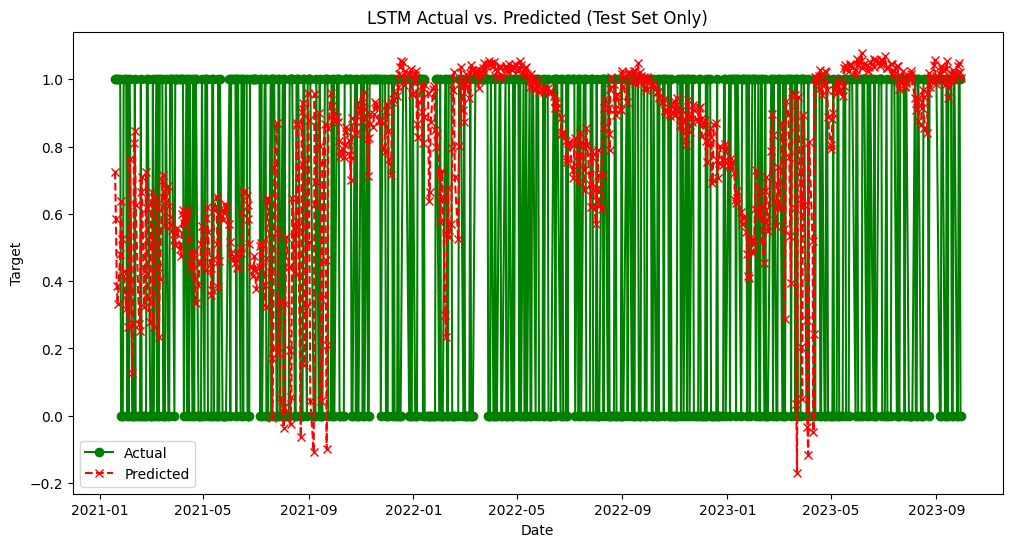

In [30]:
import matplotlib.pyplot as plt
import numpy as np

all_indices = df_lstm.index[seq_len:]
train_size = len(X_train)
test_size = len(X_test)

train_indices = all_indices[:train_size]
test_indices  = all_indices[train_size:]

y_train_np = np.array(y_train).flatten()
y_test_np = np.array(y_test).flatten()
y_pred_test_np = y_pred_test.flatten()

plt.figure(figsize=(20, 5))

plt.plot(train_indices, y_train_np, label='Training Data (actual)', color='blue')
plt.plot(test_indices, y_test_np, label='Test Data (actual)', color='green')
plt.plot(test_indices, y_pred_test_np, label='Predicted (test)', color='red', linestyle='--')

plt.xlabel("Date")
plt.ylabel("Target")
plt.title("LSTM Train & Test Data vs. Predictions")
plt.legend()
plt.show()

plt.figure(figsize=(12,6))
plt.plot(test_indices, y_test_np, label='Actual', marker='o', linestyle='-', color='green')
plt.plot(test_indices, y_pred_test_np, label='Predicted', marker='x', linestyle='--', color='red')

plt.xlabel("Date")
plt.ylabel("Target")
plt.title("LSTM Actual vs. Predicted (Test Set Only)")
plt.legend()
plt.show()